# MP4

## Enviroment

In [ ]:
# Install necessary packages
!apt-get update
!apt-get install -y xvfb x11-utils
!pip install gymnasium pygame pyvirtualdisplay

# Create a virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

import gymnasium as gym
from gym import spaces
import numpy as np
import random
import pygame

class WumpusWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=4):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.cell_size = self.window_size // self.size  # Size of each cell
        self.render_mode = render_mode

        # Observations include the agent's location, Wumpus's location, and binary indicators for gold and pit
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "wumpus": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "gold": spaces.Discrete(2),  # 0 for not at agent's location, 1 for at agent's location
            "pit": spaces.Discrete(2)     # 0 for not at agent's location, 1 for at agent's location
        })

        # Action space: 0 = left, 1 = right, 2 = up, 3 = down, 4 = shoot left, 5 = shoot right, 6 = shoot up, 7 = shoot down
        self.action_space = spaces.Discrete(8)

        # Initialize positions of the agent, gold, wumpus, and pit
        self.agent_start_pos = np.array([0, 0])
        self.agent_pos = self.agent_start_pos.copy()
        self.gold_pos = np.array([3, 1])
        self.wumpus_pos = np.array([0, 3])
        self.pit_pos = np.array([1, 3])
        self.wumpus_alive = True
        self.total_reward = 0

        if self.render_mode == 'human':
            pygame.init()
            self.screen = pygame.display.set_mode((self.window_size, self.window_size))
            pygame.display.set_caption("Wumpus World")

    def reset(self):
        self.agent_pos = self.agent_start_pos.copy()
        self.wumpus_pos = np.array([0, 3])
        self.wumpus_alive = True
        self.total_reward = 0
        return self._get_obs()

    def step(self, action):
        reward = 0  # Initial reward
        done = False

        if action < 4:  # Movement actions
            if self._valid_move(self.agent_pos, action):
                self._move(self.agent_pos, action)
                reward = -1  # Movement penalty
        elif self.wumpus_alive:  # Shoot actions
            if self._shoot(action):
                reward = 50

        # Check for terminal states
        if np.array_equal(self.agent_pos, self.gold_pos):
            reward = +1000  # Reward for finding gold
            done = True
        elif np.array_equal(self.agent_pos, self.pit_pos):
            reward = -1000  # Penalty for falling into pit
            done = True
        elif np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
            reward = -1000  # Penalty for getting eaten by the Wumpus
            done = True

        # Move the Wumpus if it is still alive
        if not done and self.wumpus_alive:
            wumpus_action = random.choice([0, 1, 2, 3])
            if self._valid_move(self.wumpus_pos, wumpus_action):
                self._move(self.wumpus_pos, wumpus_action)

            # Check if the Wumpus eats the agent after moving
            if np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
                reward = -1000  # Penalty for getting eaten by the Wumpus
                done = True

        self.total_reward += reward
        print(f"Action: {action}, Reward: {reward}, Total Reward: {self.total_reward}, Done: {done}, Wumpus Alive: {self.wumpus_alive}")
        return self._get_obs(), reward, done, {}

    def _move(self, pos, action):
        if action == 0 and pos[1] > 0:  # left
            pos[1] -= 1
        elif action == 1 and pos[1] < self.size - 1:  # right
            pos[1] += 1
        elif action == 2 and pos[0] > 0:  # up
            pos[0] -= 1
        elif action == 3 and pos[0] < self.size - 1:  # down
            pos[0] += 1

    def _valid_move(self, pos, action):
        if action == 0 and pos[1] == 0:  # left
            return False
        elif action == 1 and pos[1] == self.size - 1:  # right
            return False
        elif action == 2 and pos[0] == 0:  # up
            return False
        elif action == 3 and pos[0] == self.size - 1:  # down
            return False
        return True

    def _shoot(self, action):
        if not self.wumpus_alive:
            return False

        if action == 4:  # shoot left
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] > self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 5:  # shoot right
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] < self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 6:  # shoot up
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] > self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        elif action == 7:  # shoot down
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] < self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        return False

    def _get_obs(self):
        return {
            "agent": self.agent_pos.copy(),
            "wumpus": self.wumpus_pos.copy(),
            "gold": int(np.array_equal(self.agent_pos, self.gold_pos)),
            "pit": int(np.array_equal(self.agent_pos, self.pit_pos))
        }

    def render(self, mode="human"):
        if mode == 'human':
            self.screen.fill((255, 255, 255))  # Fill the screen with white

            # Draw the grid
            for x in range(0, self.window_size, self.cell_size):
                for y in range(0, self.window_size, self.cell_size):
                    rect = pygame.Rect(x, y, self.cell_size, self.cell_size)
                    pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

            # Draw the agent
            agent_rect = pygame.Rect(
                self.agent_pos[1] * self.cell_size,
                self.agent_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 255), agent_rect)  # Blue color

            # Draw the Wumpus
            if self.wumpus_alive:
                wumpus_rect = pygame.Rect(
                    self.wumpus_pos[1] * self.cell_size,
                    self.wumpus_pos[0] * self.cell_size,
                    self.cell_size, self.cell_size
                )
                pygame.draw.rect(self.screen, (255, 0, 0), wumpus_rect)  # Red color

            # Draw the gold
            gold_rect = pygame.Rect(
                self.gold_pos[1] * self.cell_size,
                self.gold_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (255, 215, 0), gold_rect)  # Gold color

            # Draw the pit
            pit_rect = pygame.Rect(
                self.pit_pos[1] * self.cell_size,
                self.pit_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 0), pit_rect)  # Black color

            pygame.display.flip()  # Update the full display surface to the screen
        elif mode == 'rgb_array':
            # Not implemented in this example
            pass

    def close(self):
        if self.render_mode == 'human':
            pygame.quit()

env = WumpusWorldEnv(render_mode="human")


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [858 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,410 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,674 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.

## Q-Learning

Installing the necessary packages

In [ ]:
!apt-get update
!apt-get install -y xvfb x11-utils
!pip install gymnasium pygame pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [858 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,674 kB]
Get:13 http://security.ubuntu.com/u

Creating a virtual display

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Defining the Wumpus World environment

In [ ]:
import gymnasium as gym
from gym import spaces
import numpy as np
import random
import pygame

class WumpusWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=4):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.cell_size = self.window_size // self.size  # Size of each cell
        self.render_mode = render_mode

        # Observations include the agent's location, Wumpus's location, and binary indicators for gold and pit
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "wumpus": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "gold": spaces.Discrete(2),  # 0 for not at agent's location, 1 for at agent's location
            "pit": spaces.Discrete(2)     # 0 for not at agent's location, 1 for at agent's location
        })

        # Action space: 0 = left, 1 = right, 2 = up, 3 = down, 4 = shoot left, 5 = shoot right, 6 = shoot up, 7 = shoot down
        self.action_space = spaces.Discrete(8)

        # Initialize positions of the agent, gold, wumpus, and pit
        self.agent_start_pos = np.array([0, 0])
        self.agent_pos = self.agent_start_pos.copy()
        self.gold_pos = np.array([3, 1])
        self.wumpus_pos = np.array([0, 3])
        self.pit_pos = np.array([1, 3])
        self.wumpus_alive = True
        self.total_reward = 0

        if self.render_mode == 'human':
            pygame.init()
            self.screen = pygame.display.set_mode((self.window_size, self.window_size))
            pygame.display.set_caption("Wumpus World")

    def reset(self):
        self.agent_pos = self.agent_start_pos.copy()
        self.wumpus_pos = np.array([0, 3])
        self.wumpus_alive = True
        self.total_reward = 0
        return self._get_obs()

    def step(self, action):
        reward = 0  # Initial reward
        done = False

        if action < 4:  # Movement actions
            if self._valid_move(self.agent_pos, action):
                self._move(self.agent_pos, action)
                reward = -1  # Movement penalty
        elif self.wumpus_alive:  # Shoot actions
            if self._shoot(action):
                reward = 50

        # Check for terminal states
        if np.array_equal(self.agent_pos, self.gold_pos):
            reward = +1000  # Reward for finding gold
            done = True
        elif np.array_equal(self.agent_pos, self.pit_pos):
            reward = -1000  # Penalty for falling into pit
            done = True
        elif np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
            reward = -1000  # Penalty for getting eaten by the Wumpus
            done = True

        # Move the Wumpus if it is still alive
        if not done and self.wumpus_alive:
            wumpus_action = random.choice([0, 1, 2, 3])
            if self._valid_move(self.wumpus_pos, wumpus_action):
                self._move(self.wumpus_pos, wumpus_action)

            # Check if the Wumpus eats the agent after moving
            if np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
                reward = -1000  # Penalty for getting eaten by the Wumpus
                done = True

        self.total_reward += reward
        return self._get_obs(), reward, done, {}

    def _move(self, pos, action):
        if action == 0 and pos[1] > 0:  # left
            pos[1] -= 1
        elif action == 1 and pos[1] < self.size - 1:  # right
            pos[1] += 1
        elif action == 2 and pos[0] > 0:  # up
            pos[0] -= 1
        elif action == 3 and pos[0] < self.size - 1:  # down
            pos[0] += 1

    def _valid_move(self, pos, action):
        if action == 0 and pos[1] == 0:  # left
            return False
        elif action == 1 and pos[1] == self.size - 1:  # right
            return False
        elif action == 2 and pos[0] == 0:  # up
            return False
        elif action == 3 and pos[0] == self.size - 1:  # down
            return False
        return True

    def _shoot(self, action):
        if not self.wumpus_alive:
            return False

        if action == 4:  # shoot left
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] > self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 5:  # shoot right
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] < self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 6:  # shoot up
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] > self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        elif action == 7:  # shoot down
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] < self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        return False

    def _get_obs(self):
        return {
            "agent": self.agent_pos.copy(),
            "wumpus": self.wumpus_pos.copy(),
            "gold": int(np.array_equal(self.agent_pos, self.gold_pos)),
            "pit": int(np.array_equal(self.agent_pos, self.pit_pos))
        }

    def render(self, mode="human"):
        if mode == 'human':
            self.screen.fill((255, 255, 255))  # Fill the screen with white

            # Draw the grid
            for x in range(0, self.window_size, self.cell_size):
                for y in range(0, self.window_size, self.cell_size):
                    rect = pygame.Rect(x, y, self.cell_size, self.cell_size)
                    pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

            # Draw the agent
            agent_rect = pygame.Rect(
                self.agent_pos[1] * self.cell_size,
                self.agent_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 255), agent_rect)  # Blue color

            # Draw the Wumpus
            if self.wumpus_alive:
                wumpus_rect = pygame.Rect(
                    self.wumpus_pos[1] * self.cell_size,
                    self.wumpus_pos[0] * self.cell_size,
                    self.cell_size, self.cell_size
                )
                pygame.draw.rect(self.screen, (255, 0, 0), wumpus_rect)  # Red color

            # Draw the gold
            gold_rect = pygame.Rect(
                self.gold_pos[1] * self.cell_size,
                self.gold_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (255, 215, 0), gold_rect)  # Gold color

            # Draw the pit
            pit_rect = pygame.Rect(
                self.pit_pos[1] * self.cell_size,
                self.pit_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 0), pit_rect)  # Black color

            pygame.display.flip()  # Update the full display surface to the screen
        elif mode == 'rgb_array':
            # Not implemented in this example
            pass

    def close(self):
        if self.render_mode == 'human':
            pygame.quit()

env = WumpusWorldEnv(render_mode="human")

Executing Q-learning code

Streaming output truncated to the last 5000 lines.
Episode 149, Step 1: Agent Position = [0 1], Wumpus Position = [1 3], Action = 1, Reward = -1
Episode 149, Step 2: Agent Position = [1 1], Wumpus Position = [1 3], Action = 3, Reward = -1
Episode 149, Step 3: Agent Position = [1 1], Wumpus Position = [0 3], Action = 6, Reward = 0
Episode 149, Step 4: Agent Position = [2 1], Wumpus Position = [1 3], Action = 3, Reward = -1
Episode 149, Step 5: Agent Position = [3 1], Wumpus Position = [1 3], Action = 3, Reward = 1000
Episode 150, Step 1: Agent Position = [0 0], Wumpus Position = [0 3], Action = 7, Reward = 0
Episode 150, Step 2: Agent Position = [0 1], Wumpus Position = [0 3], Action = 1, Reward = -1
Episode 150, Step 3: Agent Position = [1 1], Wumpus Position = [0 2], Action = 3, Reward = -1
Episode 150, Step 4: Agent Position = [2 1], Wumpus Position = [1 2], Action = 3, Reward = -1
Episode 150, Step 5: Agent Position = [2 1], Wumpus Position = [1 3], Action = 5, Reward = 0
Episode 15

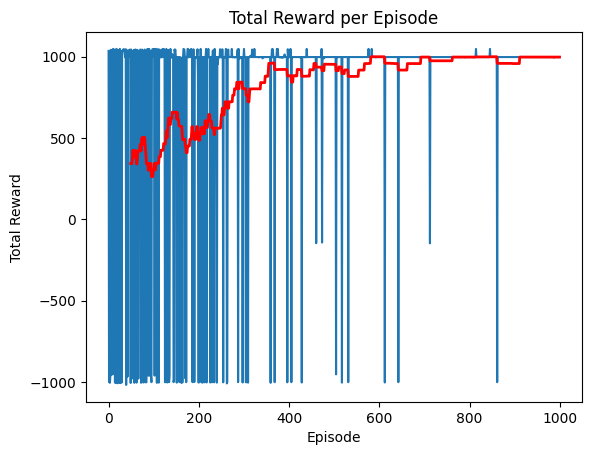

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate
episodes = 1000
max_steps = 200  # Maximum steps per episode
moving_avg_period = 50  # Period for calculating moving average

# Initialize Q-table
q_table = np.zeros((env.size, env.size, env.size, env.size, 2, 2, env.action_space.n))

def get_state(obs):
    agent_pos = obs['agent']
    wumpus_pos = obs['wumpus']
    gold = obs['gold']
    pit = obs['pit']
    return (agent_pos[0], agent_pos[1], wumpus_pos[0], wumpus_pos[1], gold, pit)

def get_valid_actions(env):
    valid_actions = []
    for action in range(env.action_space.n):
        if action < 4:  # Movement actions
            if env._valid_move(env.agent_pos, action):
                valid_actions.append(action)
        else:  # Shooting actions
            if env.wumpus_alive:
                valid_actions.append(action)
    return valid_actions

def moving_average(data, period):
    return np.convolve(data, np.ones(period) / period, mode='valid')


rewards = []

for episode in range(episodes):
    state = get_state(env.reset())
    total_reward = 0
    done = False
    steps = 0

    while not done and steps < max_steps:
        valid_actions = get_valid_actions(env)

        if np.random.rand() < epsilon:
            # Sample a valid action
            action = np.random.choice(valid_actions)
        else:
            # Choose the best valid action
            q_values = q_table[state]
            sorted_actions = np.argsort(q_values)[::-1]
            action = None
            for a in sorted_actions:
                if a in valid_actions:
                    action = a
                    break

        obs, reward, done, _ = env.step(action)
        next_state = get_state(obs)

        total_reward += reward

        best_next_action = np.argmax(q_table[next_state])
        q_table[state + (action,)] += alpha * (reward + gamma * q_table[next_state + (best_next_action,)] - q_table[state + (action,)])

        state = next_state
        steps += 1

        # Print positions and action
        print(f"Episode {episode}, Step {steps}: Agent Position = {env.agent_pos}, Wumpus Position = {env.wumpus_pos}, Action = {action}, Reward = {reward}")

    rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 10 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}")

print("Training finished.\n")
# Calculate moving average of rewards
mean_rewards = moving_average(rewards, moving_avg_period)

# Plot the rewards
plt.plot(rewards)
plt.plot(range(moving_avg_period - 1, episodes), mean_rewards, label='Mean Total Reward', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


## DQN

Installing the necessary packages

In [ ]:
!apt-get update
!apt-get install -y xvfb x11-utils
!pip install gymnasium pygame pyvirtualdisplay torch matplotlib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,601 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,674 kB]
Get:13 http://security.ubuntu.com/ubuntu ja

Creating a virtual display

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Defining the Wumpus World environment

In [12]:
import gymnasium as gym
from gym import spaces
import numpy as np
import random
import pygame

class WumpusWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=4):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.cell_size = self.window_size // self.size  # Size of each cell
        self.render_mode = render_mode

        # Observations include the agent's location, Wumpus's location, and binary indicators for gold and pit
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "wumpus": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "gold": spaces.Discrete(2),  # 0 for not at agent's location, 1 for at agent's location
            "pit": spaces.Discrete(2)     # 0 for not at agent's location, 1 for at agent's location
        })

        # Action space: 0 = left, 1 = right, 2 = up, 3 = down, 4 = shoot left, 5 = shoot right, 6 = shoot up, 7 = shoot down
        self.action_space = spaces.Discrete(8)

        # Initialize positions of the agent, gold, wumpus, and pit
        self.agent_start_pos = np.array([0, 0])
        self.agent_pos = self.agent_start_pos.copy()
        self.gold_pos = np.array([3, 1])
        self.wumpus_pos = np.array([0, 3])
        self.pit_pos = np.array([1, 3])
        self.wumpus_alive = True
        self.total_reward = 0

        if self.render_mode == 'human':
            pygame.init()
            self.screen = pygame.display.set_mode((self.window_size, self.window_size))
            pygame.display.set_caption("Wumpus World")

    def reset(self):
        self.agent_pos = self.agent_start_pos.copy()
        self.wumpus_pos = np.array([0, 3])
        self.wumpus_alive = True
        self.total_reward = 0
        return self._get_obs()

    def step(self, action):
        reward = 0  # Initial reward
        done = False

        if action < 4:  # Movement actions
            if self._valid_move(self.agent_pos, action):
                self._move(self.agent_pos, action)
                reward = 0  # Movement penalty
        elif self.wumpus_alive:  # Shoot actions
            if self._shoot(action):
                reward = 50

        # Check for terminal states
        if np.array_equal(self.agent_pos, self.gold_pos):
            reward = +1000  # Reward for finding gold
            done = True
        elif np.array_equal(self.agent_pos, self.pit_pos):
            reward = -1000  # Penalty for falling into pit
            done = True
        elif np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
            reward = -1000  # Penalty for getting eaten by the Wumpus
            done = True

        # Move the Wumpus if it is still alive
        if not done and self.wumpus_alive:
            wumpus_action = random.choice([0, 1, 2, 3])
            if self._valid_move(self.wumpus_pos, wumpus_action):
                self._move(self.wumpus_pos, wumpus_action)

            # Check if the Wumpus eats the agent after moving
            if np.array_equal(self.agent_pos, self.wumpus_pos) and self.wumpus_alive:
                reward = -1000  # Penalty for getting eaten by the Wumpus
                done = True

        self.total_reward += reward
        return self._get_obs(), reward, done, {}

    def _move(self, pos, action):
        if action == 0 and pos[1] > 0:  # left
            pos[1] -= 1
        elif action == 1 and pos[1] < self.size - 1:  # right
            pos[1] += 1
        elif action == 2 and pos[0] > 0:  # up
            pos[0] -= 1
        elif action == 3 and pos[0] < self.size - 1:  # down
            pos[0] += 1

    def _valid_move(self, pos, action):
        if action == 0 and pos[1] == 0:  # left
            return False
        elif action == 1 and pos[1] == self.size - 1:  # right
            return False
        elif action == 2 and pos[0] == 0:  # up
            return False
        elif action == 3 and pos[0] == self.size - 1:  # down
            return False
        return True

    def _shoot(self, action):
        if not self.wumpus_alive:
            return False

        if action == 4:  # shoot left
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] > self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 5:  # shoot right
            if self.agent_pos[0] == self.wumpus_pos[0] and self.agent_pos[1] < self.wumpus_pos[1]:
                self.wumpus_alive = False
                return True
        elif action == 6:  # shoot up
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] > self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        elif action == 7:  # shoot down
            if self.agent_pos[1] == self.wumpus_pos[1] and self.agent_pos[0] < self.wumpus_pos[0]:
                self.wumpus_alive = False
                return True
        return False

    def _get_obs(self):
        return {
            "agent": self.agent_pos.copy(),
            "wumpus": self.wumpus_pos.copy(),
            "gold": int(np.array_equal(self.agent_pos, self.gold_pos)),
            "pit": int(np.array_equal(self.agent_pos, self.pit_pos))
        }

    def render(self, mode="human"):
        if mode == 'human':
            self.screen.fill((255, 255, 255))  # Fill the screen with white

            # Draw the grid
            for x in range(0, self.window_size, self.cell_size):
                for y in range(0, self.window_size, self.cell_size):
                    rect = pygame.Rect(x, y, self.cell_size, self.cell_size)
                    pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

            # Draw the agent
            agent_rect = pygame.Rect(
                self.agent_pos[1] * self.cell_size,
                self.agent_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 255), agent_rect)  # Blue color

            # Draw the Wumpus
            if self.wumpus_alive:
                wumpus_rect = pygame.Rect(
                    self.wumpus_pos[1] * self.cell_size,
                    self.wumpus_pos[0] * self.cell_size,
                    self.cell_size, self.cell_size
                )
                pygame.draw.rect(self.screen, (255, 0, 0), wumpus_rect)  # Red color

            # Draw the gold
            gold_rect = pygame.Rect(
                self.gold_pos[1] * self.cell_size,
                self.gold_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (255, 215, 0), gold_rect)  # Gold color

            # Draw the pit
            pit_rect = pygame.Rect(
                self.pit_pos[1] * self.cell_size,
                self.pit_pos[0] * self.cell_size,
                self.cell_size, self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 0), pit_rect)  # Black color

            pygame.display.flip()  # Update the full display surface to the screen
        elif mode == 'rgb_array':
            # Not implemented in this example
            pass

    def close(self):
        if self.render_mode == 'human':
            pygame.quit()

env = WumpusWorldEnv(render_mode="human")

Executing DQN code

Episode 0, Total Reward: -1000, Epsilon: 0.95
Episode 1, Total Reward: -1000, Epsilon: 0.9025
Episode 2, Total Reward: -950, Epsilon: 0.8573749999999999
Episode 3, Total Reward: -950, Epsilon: 0.8145062499999999
Episode 4, Total Reward: -1000, Epsilon: 0.7737809374999999
Episode 5, Total Reward: -1000, Epsilon: 0.7350918906249998
Episode 6, Total Reward: -950, Epsilon: 0.6983372960937497
Episode 7, Total Reward: -1000, Epsilon: 0.6634204312890623
Episode 8, Total Reward: -950, Epsilon: 0.6302494097246091
Episode 9, Total Reward: -950, Epsilon: 0.5987369392383786
Episode 10, Total Reward: 1050, Epsilon: 0.5688000922764596
Episode 11, Total Reward: -950, Epsilon: 0.5403600876626365
Episode 12, Total Reward: 1050, Epsilon: 0.5133420832795047
Episode 13, Total Reward: 1050, Epsilon: 0.48767497911552943
Episode 14, Total Reward: 1050, Epsilon: 0.46329123015975293
Episode 15, Total Reward: 1000, Epsilon: 0.44012666865176525
Episode 16, Total Reward: 1050, Epsilon: 0.41812033521917696
Episode

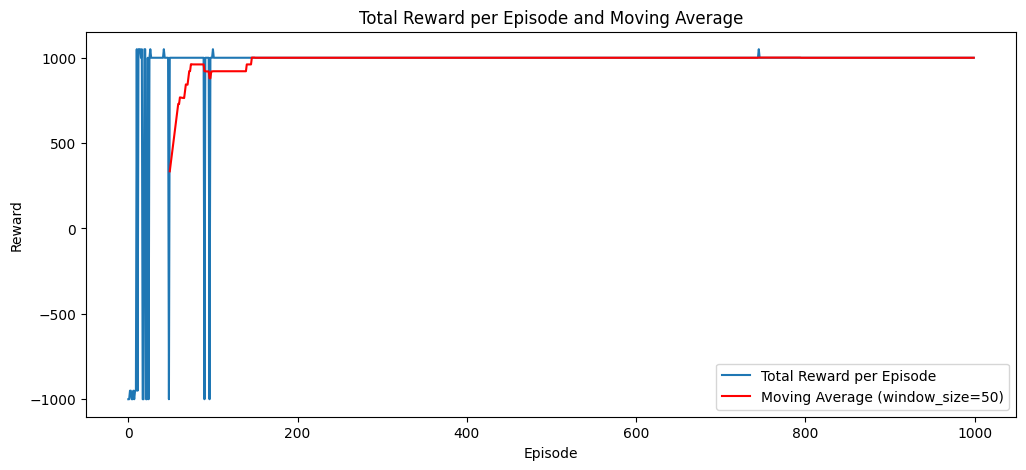

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.5, epsilon=1.0, epsilon_decay=0.95, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(10000)
        self.batch_size = 64

    def select_action(self, state):
        if random.random() > self.epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        state, action, reward, next_state, done = self.memory.sample(self.batch_size)

        state = torch.FloatTensor(state).to(self.device)
        action = torch.LongTensor(action).unsqueeze(1).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        q_values = self.policy_net(state).gather(1, action)
        next_q_values = self.target_net(next_state).max(1)[0].detach()
        expected_q_values = reward + (1 - done) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


def train_dqn(env, agent, num_episodes):
    reward_history = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.concatenate([state['agent'], state['wumpus'], [state['gold']], [state['pit']]])
        total_reward = 0

        for t in range(1000):  # Limit each episode to 1000 steps
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.concatenate([next_state['agent'], next_state['wumpus'], [next_state['gold']], [next_state['pit']]])
            agent.memory.push(state, action, reward, next_state, done)
            agent.train_step()

            state = next_state
            total_reward += reward

            if done:
                break

        agent.update_target()
        reward_history.append(total_reward)

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return reward_history

# Initialize the environment and agent
env = WumpusWorldEnv()
state_dim = 6  # agent (2) + wumpus (2) + gold (1) + pit (1)
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

# Train the agent
num_episodes = 1000
reward_history = train_dqn(env, agent, num_episodes)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Calculate the moving average of the rewards
window_size = 50
moving_avg_rewards = moving_average(reward_history, window_size)

# Plot the reward history and moving average
plt.figure(figsize=(12, 5))
plt.plot(reward_history, label='Total Reward per Episode')
plt.plot(np.arange(window_size - 1, num_episodes), moving_avg_rewards, label=f'Moving Average (window_size={window_size})', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Reward per Episode and Moving Average')
plt.legend()
plt.show()